<a href="https://colab.research.google.com/github/ge43jef/GEEHYDRO/blob/Final/SVRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pandas as pd
from glob import glob

files = glob('FLX*')

dataframes = []

columns = ["SW_IN_F","LW_IN_F", "PA_F", "WS_F", "VPD_F", "temperature_2m", "total_precipitation_sum", "LE_CORR"]

for file in files:
    df = pd.read_excel(file, usecols=columns, header=0)
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

In [59]:
count_9999 = (combined_df["LE_CORR"] == -9999).sum()
print("Number of values with -9999 in LE_CORR:", count_9999)

Number of values with -9999 in LE_CORR: 121


In [60]:
combined_df = combined_df[combined_df["LE_CORR"] != -9999]
combined_df.shape

(17409, 8)

In [61]:
X = combined_df.drop("LE_CORR", axis=1)
y = combined_df["LE_CORR"].values.reshape(-1, 1)

print(type(X))

<class 'pandas.core.frame.DataFrame'>


In [69]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of StandardScaler
scaler = MinMaxScaler()

# Scale the X DataFrame
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#y = y.reshape(len(y), 1)
y = scaler.fit_transform(y)
print(type(y))

<class 'numpy.ndarray'>


# **Support Vector Regression (SVR) **

---



In [70]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

1. Cross-validation

In [77]:
#splliting the data to test and train set
y = y.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [78]:
svr = SVR()

scores = cross_val_score(svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print("Cross-validated RMSE scores:", rmse_scores)

Cross-validated RMSE scores: [0.08369267 0.08057508 0.08087062 0.08077491 0.08323378]


In [79]:
predicted_values = cross_val_predict(svr,  X_train, y_train, cv=5)

# Calculate RMSE based on cross-validated predictions
mse = mean_squared_error(y_train, predicted_values)
rmse = np.sqrt(mse)
print("Cross-validated RMSE:", rmse)

Cross-validated RMSE: 0.08184060945337575


2. Hyperparameter tuning

In [80]:
paramGrid = {
    'kernel': ['rbf'],
    'C': [10, 100],
    'epsilon': [0.1, 0.3]
}
grid_search = GridSearchCV(svr, paramGrid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [81]:
print(best_params,best_model)

{'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'} SVR(C=100)


3. Visualizations

Validation curve

In [37]:
!pip install --upgrade scikit-learn


ERROR: Operation cancelled by user


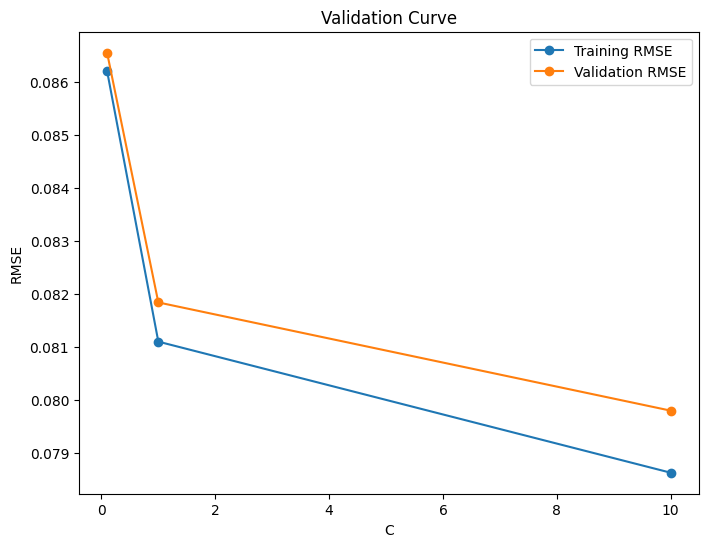

In [82]:
param_range = [0.1, 1, 10]
train_scores, val_scores = validation_curve(best_model, X_train, y_train, param_name='C', param_range=param_range, cv=5, scoring='neg_mean_squared_error')
train_rmse_scores = np.sqrt(-train_scores.mean(axis=1))
val_rmse_scores = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(8, 6))
plt.plot(param_range, train_rmse_scores, 'o-', label='Training RMSE')
plt.plot(param_range, val_rmse_scores, 'o-', label='Validation RMSE')
plt.xlabel('C')
plt.ylabel('RMSE')
plt.title('Validation Curve')
plt.legend()
plt.show()

learning curve

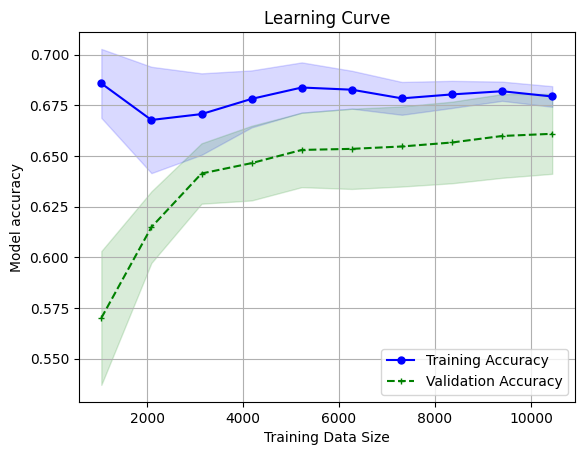

In [83]:
train_sizes, train_scores, val_scores = learning_curve(best_model, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(val_scores, axis=1)
test_std = np.std(val_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

4. Final Evaluation

In [84]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE_testdat:", rmse)
print("R2_testdata:", r2)

RMSE_testdat: 0.07787225488317231
R2_testdata: 0.6833417515733814


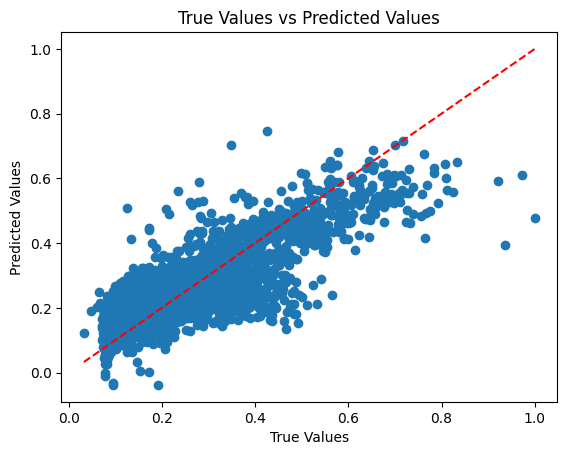

In [85]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs Predicted Values')
plt.show()